# Investigating a Drop in User Engagement

### Problem
You show up to work Tuesday morning, September 2, 2014. The head of the Product team walks over to your desk and asks you what you think about the latest activity on the user engagement dashboards (yes this really happens). You fire them up, and something immediately jumps out:


![](engagement_plot.png)

the above chart shows the number of engaged users each week. Yammer defines engagement as having made some type of server call by interacting with the product (shown in the data as events of type “engagement”). Any point in this chart can be interpreted as “the number of users who logged at least one engagement event during the week starting on that date.”
### Question:
The head of product says “Can you look into this and get me a summary by this afternoon?”  As she runs to a meeting.


## Approach

1. First, we want to identified what cause the active users to decrease in August. The cause can roughly be categorized into two types: 
    - Increase of dropout users of the previous month 
    - Decrease growth of new users
      
2. If we can identified the group causing the decrease of active user, we can then further examine the distribution of different features in August

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats


from Jimmy_Hu_Yammer_function import *

pd.options.mode.chained_assignment = None

%matplotlib inline

In [2]:
users = pd.read_csv("data/yammer_users.csv")
events = pd.read_csv("data/yammer_events.csv")
email = pd.read_csv("data/yammer_emails.csv")
period = pd.read_csv("data/dimension_rollup_periods.csv")

# Convert the date string to timestamp data type
users['created_at'] = pd.to_datetime(users['created_at'])
users['activated_at'] = pd.to_datetime(users['activated_at'])
events['occurred_at'] = pd.to_datetime(events['occurred_at'])

In [3]:
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaT,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaT,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [4]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


The user and event information are most related to the our problem. Therefore we will explore these two table first.

In [5]:
# Get all the active user's information, group by "month" and "week"
active_user = get_active_user(events, users)
active_user.head()

,month,week,user_id,events_count,last_engagement,created_at,company_id,language,activated_at,state,activate_length
0,5,18,8.0,2,2014-05-02 07:20:52,2013-01-01 04:38:30,2698.0,french,2013-01-01 04:40:10,active,486
1,5,19,8.0,15,2014-05-09 09:26:24,2013-01-01 04:38:30,2698.0,french,2013-01-01 04:40:10,active,493
2,5,20,8.0,3,2014-05-13 07:52:31,2013-01-01 04:38:30,2698.0,french,2013-01-01 04:40:10,active,497
3,5,21,8.0,9,2014-05-23 08:47:03,2013-01-01 04:38:30,2698.0,french,2013-01-01 04:40:10,active,507
4,7,31,8.0,7,2014-07-30 06:10:09,2013-01-01 04:38:30,2698.0,french,2013-01-01 04:40:10,active,575


### Does the loss of active users caused by the increase of dropout user? 

To answer the question, we calculate the dropout count and dropout rate over week. Dropout is defined as the active users who is presented in the previous week, but not in the current week. The data contains only information from May to August, which equals to from week 18 to week 35

In [6]:
drop_out_df = get_dropout_df(active_user)
drop_out_df.head()

,week,active_user,drop_out_count,drop_out_rate
0,18,701,214,0.305278
1,19,1054,424,0.402277
2,20,1094,399,0.364717
3,21,1147,490,0.427201
4,22,1186,446,0.376054


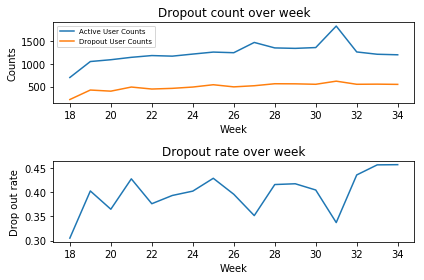

In [7]:
fig = plt.figure()

ax1 = fig.add_subplot(2,1,1 )
ax1.plot(drop_out_df.week, drop_out_df.active_user)
ax1.plot(drop_out_df.week, drop_out_df.drop_out_count)
ax1.legend(['Active User Counts', 'Dropout User Counts'], prop={'size': 7})
ax1.set_xlabel("Week")
ax1.set_ylabel("Counts")
ax1.set_title("Dropout count over week")

ax2 = fig.add_subplot(2,1,2)
ax2.plot(drop_out_df.week, drop_out_df.drop_out_rate)
ax2.set_xlabel("Week")
ax2.set_ylabel("Drop out rate")
ax2.set_title("Dropout rate over week")

plt.tight_layout()
plt.show()

Looking at the numbers of dropout users, there seems not to increase significantly. However, the counts should be influenced by the total active users, so we take a look at the drop out rate.

The second line plot shows the dropout rate. We can see that indeed dropout rate become higher in the last three weeks(32-34) are higher. 

### Does the loss of active users caused by the decrease of new users? 

Next, we calculate the new users count and new user rate over week. New users can be someone who just activate their account, or someone who didn't use for a period of time but re-activate again. For simplicity, I define the new users as the users who was not active in the previous month, but become active in the current month.


In [8]:
# Calculate the new users
new_user_df = get_newuser_df(active_user)
new_user_df.head()

,week,active_user,new_user_count,new_user_rate
0,19,1054,567,0.537951
1,20,1094,464,0.424132
2,21,1147,452,0.394071
3,22,1186,456,0.384486
4,23,1173,506,0.431373


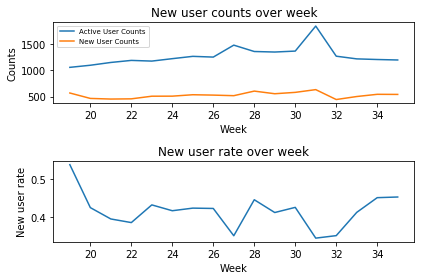

In [9]:
fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
ax1.plot(new_user_df.week, new_user_df.active_user)
ax1.plot(new_user_df.week, new_user_df.new_user_count)
ax1.legend(['Active User Counts', 'New User Counts'], prop={'size': 7})
ax1.set_xlabel("Week")
ax1.set_ylabel("Counts")
ax1.set_title("New user counts over week")

ax2 = fig.add_subplot(2,1,2)
ax2.plot(new_user_df.week, new_user_df.new_user_rate)
ax2.set_xlabel("Week")
ax2.set_ylabel("New user rate")
ax2.set_title("New user rate over week")

plt.tight_layout()
plt.show()

The new user counts did not decrease significantly at the last few weeks, so it is not likely to be the cause.

In conclusion, the reason why the weekly active users decrease in the August is caused by the __increase of the dropout users__. The next step, we will explore these users who dropout in the August.

### Explore the subgroup users that drop out in the last three weeks

We divide the users into two group:
    - august dropout users: Users who dropout in the last three weeks (week 32-34)
    - control dropout users: All the other users who dropout in before the last three weeks (week 18-31)

August dropout users has a higher dropout rate than that in the control. We want to find out what's the charateristic in this group and figure out the reason causing them to be higher.

In [10]:
# Get the dropout user id in two groups
aug_drop_user_id = get_dropout_user_id(active_user, 32, 35)
control_drop_user_id = get_dropout_user_id(active_user, 18,32)

In [11]:
# Get the information for individual users in two groups
aug_drop_users = active_user[active_user.user_id.isin(aug_drop_user_id)]
aug_drop_users = aug_drop_users[aug_drop_users.week.isin(range(32,35))]
aug_drop_users = aug_drop_users.drop_duplicates(subset='user_id', keep="last")


control_drop_users = active_user[active_user.user_id.isin(control_drop_user_id)]
control_drop_users = control_drop_users[control_drop_users.week.isin(range(18,32))]
control_drop_users = control_drop_users.drop_duplicates(subset='user_id', keep="last")

In [12]:
aug_drop_users.head()

,month,week,user_id,events_count,last_engagement,created_at,company_id,language,activated_at,state,activate_length
89,8,32,319.0,5,2014-08-07 09:32:49,2013-01-31 00:34:12,3.0,spanish,2013-01-31 00:35:43,active,553
95,8,33,365.0,27,2014-08-14 15:08:55,2013-02-04 03:53:48,10053.0,spanish,2013-02-04 03:55:18,active,556
127,8,32,492.0,9,2014-08-05 12:19:36,2013-02-14 13:11:47,8821.0,english,2013-02-14 13:13:04,active,536
158,8,32,591.0,5,2014-08-07 18:03:10,2013-02-22 13:28:31,3.0,italian,2013-02-22 13:29:41,active,531
210,8,34,822.0,5,2014-08-19 10:35:34,2013-03-14 10:59:09,11195.0,english,2013-03-14 11:00:18,active,522


### Difference in activation time?

First we suspect that the reason why users have higher dropout rate in August is because they had used the product for a longer time. In other word, these users have higher "activate length" - which I defined as the time between the account was activated and the last engagement time. 

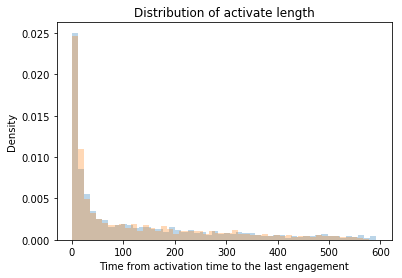

In [13]:
plt.hist(aug_drop_users.activate_length, density=True, alpha = 0.3, bins=50)
plt.hist(control_drop_users.activate_length, density=True, alpha = 0.3, bins=50)
plt.xlabel("Time from activation time to the last engagement")
plt.ylabel("Density")
plt.title("Distribution of activate length")
plt.show()

Looking at the distribution, there seems to be no difference in the activate length. It is probably not a good indicator to explain the difference in two groups.

### Difference in language?

Next, we see are there diffence in the language

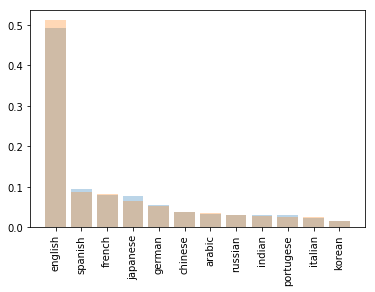

In [14]:
languages = aug_drop_users.language.value_counts().index
plt.bar(languages, aug_drop_users.language.value_counts(normalize=True), alpha = 0.3)
plt.bar(languages, control_drop_users.language.value_counts(normalize=True), alpha = 0.3)
plt.xticks(rotation='vertical')
plt.show()

Again, the language have similar distribution in two groups. There seems to be no difference in the characteristic of the users it self. So the next step, we take a look at the features of each "events".

In [15]:
# Get the events in two different group
aug_drop_events = get_dropout_events(events, aug_drop_user_id, 32,35)
control_drop_events = get_dropout_events(events, control_drop_user_id, 18,32)

### Difference in the event locations?

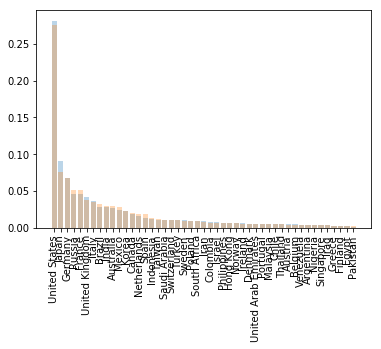

In [16]:
location = aug_drop_events.location.value_counts().index
plt.bar(location, aug_drop_events.location.value_counts(normalize=True), alpha = 0.3)
plt.bar(location, control_drop_events.location.value_counts(normalize=True), alpha = 0.3)
plt.xticks(rotation='vertical')
plt.show()

There are slightly more events in Japan for the August dropout group, but not looking signicant.

### Difference in the devices?

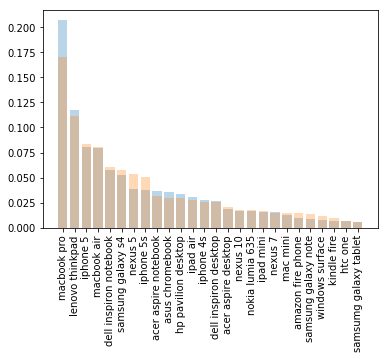

In [17]:
device = aug_drop_events.device.value_counts().index
plt.bar(device, aug_drop_events.device.value_counts(normalize=True), alpha = 0.3)
plt.bar(device, control_drop_events.device.value_counts(normalize=True), alpha = 0.3)
plt.xticks(rotation='vertical')
plt.show()

This time we that there is an difference in macbook pro. Users who use the macbook pro in August seems to have higher dropout rate. To examine the difference, we perform a chi-square test.

In [18]:
# Perform chi-square test on the macbook pro events between two groups
aug_mac = aug_drop_events.device.value_counts()['macbook pro']
aug_other = aug_drop_events.device.count() - aug_mac
con_mac = control_drop_events.device.value_counts()['macbook pro']
con_other = control_drop_events.device.count() - con_mac
mat = np.array([[aug_mac, aug_other],[con_mac, con_other]])

chi2, p, dof, ex = stats.chi2_contingency(mat)
print("p-value:" + str(p))


p-value:6.577227714518121e-60


The p-value is extremely small! The macbook pro events is actually difference in these two group!

## Summary

1. To answer why there is a drop in the user engagement, I first determine the cause by looking at "users who drop out" and "new users". Users dropout rate increased in August, while new users rates did not decrease. Therefore, the drop in engagement is caused by higher dropout rate.

2. Then I look at the features of these dropout users, including active length, languages, location, devices. There is a subtantially difference in the devices -- People who use macbook pro in the August have higher dropout rate.

3. The next step will be exploring why macbook pro users tend to dropout. Possible hypothesis:
    - There is a competition product on MacOS system announcing in August, causing these user shifting to other platform
    - There are bugs or other problem on MacOS version, causing bad user experience
    - There is updated in MacOS version in August, which may be incompatible with Yammer

